# Explore Simple QA

### Sources

`Simple QA` dataset downloaded from: https://www.dropbox.com/s/tohrsllcfy7rch4/SimpleQuestions_v2.tgz

`Freebase Triples` downloaded from: https://developers.google.com/freebase/

In `Freebase to PostgreSQL` notebook, code is provided for building up a PostgreSQL with Freebase.

### Background On Data Collection

Knowledge Bases contain facts expressed as triples (subject, relationship, object), where subject and object are entities and relationship describes the type of (directed) link between these entities. The simple QA problem we address here consist in finding the answer to questions that can be rephrased as queries of the form (subject, relationship, ?), asking for all objects linked to subject by relationship.

The question What do Jamaican people speak ?, for instance, could be rephrased as the Freebase query (jamaica, language spoken, ?). In other words, fetching a single fact from a KB is sufficient to answer correctly.

### Experiments

- Question Consistency:
    - [ ] Hypothesis some questions do not fit the distribution. Look at the bottom 1% of questions that have unique tokens. We known double spaces or question marks are not consistent.
- Entity Detection
    - [x] Hypothesis is that the object to be detected is not found in the question. Figure out how many objects are not in the question.
    - [ ] Experiment with CRF and copy model for entity detection.
- Entity Linking
    - [x] Santity check that the true object is in FB5M.
    - [x] Santity check all MIDs have an associated english name.
    - [x] Hypothesis that objects have duplicates. Given the true object, measure how many duplicates need to be parsed through on the validation set. 
        - [ ] Hypothesis there are external features that help linking. Experiment with which features best predict the object.
            - [ ] Hypothesis is that type of the entity could help disambiguate duplicates.
- Relation Detection
    - [x] Hypothesis that some of the relations occur in dev and do not occur in train. Measure this affect.
        - [ ] Hypothesis that the unknown relations can be extrapolated from words. Check if some of the relation words are unknown.
        - [ ] Hypothesis that the unknown relations can be extrapolated from words. Check which levels 1, 2 or 3 are unknown in the relation.
        - [ ] Experiment with beam search for relations and word tokenization. Beam search will help us get the top 2 - 3 beams.
    - [ ] Hypothesis that questions without entities map to the same relations; it's impossible to tell between some relations; therefore, it's not possible to predict the relation.
- Relation and Entity to Fact
    - [x] Santity check that FB5M has the facts corresponding to the answer given the true relation and the true entity.
    

Reference: https://research.fb.com/wp-content/uploads/2016/11/large-scale_simple_question_answering_with_memory_networks.pdf?
    
### Setup

Setup system path for local imports.

In [16]:
import sys
sys.path.insert(0, '../../')

Connect to PostgresSQL to run experiments.

In [19]:
from scripts.utils.connect import get_connection 

connection = get_connection()
cursor = connection.cursor()

Load up the development and train data.

In [23]:
from sklearn.utils import shuffle
from scripts.utils.simple_qa import load_simple_qa 

df_dev, = load_simple_qa(dev=True)
df_dev = shuffle(df_dev, random_state=123)
df_dev[:5]

,subject,relation,object,question
6219,03k3r,biology/organism_classification/organisms_of_t...,0bs56bp,Name an American Thoroughbread racehorse
3364,02qlppc,cvg/computer_videogame/cvg_genre,01sjng,what kind of game is vision racing driving sim...
9374,02l7c8,tv/tv_genre/programs,0dlmm88,what tv program is romance film
10142,049_zj3,location/location/containedby,04rrx,what state is polaski located in
97,02w9ycr,people/deceased_person/cause_of_death,0qcr0,what disease claimed the life of fern emmett


In [25]:
df_train, = load_simple_qa(train=True)
df_train = shuffle(df_train, random_state=123)
df_train[:5]

,subject,relation,object,question
67691,0fqd80r,music/artist/genre,01kcty,what type of musician is bruna cara considered
60980,01v7rw,book/written_work/subjects,07dg1,what is the book troilus and cressida about
44045,03fl5vh,music/release/track,0x7w6c,what is a single on the release busted
35944,05sq1b,common/topic/notable_types,01xpjyz,what is the duluth international airport
44254,03yzs66,music/release/track_list,0n2nvvl,what song is on the release welcome to haiti: ...


## Santity: True Entity and True Relation map to True Subject 

Ensure that the facts used to build the row are present in the FB5M dataset. This invariant must hold true.

In [5]:
from tqdm import tqdm_notebook
from IPython.display import display, Markdown

def check_fact_invariant(df):
    n_failed = 0.0
    for _, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        sql = """SELECT count(*)
        FROM fb_kg
        WHERE object_mid='{object_mid}'
        AND relation='{relation}'
        AND subject_mid='{subject_mid}'
        """.format(object_mid=row['object'],
                   relation=row['relation'],
                   subject_mid=row['subject'])

        cursor.execute(sql)
        n_rows = cursor.fetchone()[0]
        if n_rows == 0:
            print('\n[%d] FACT NOT FOUND' % n_failed)
            print('SQL: %s' % (sql))
            n_failed += 1

    
    display(Markdown(
        '### Numbers\n' + 
        'Facts in not found in KG FB5M\n' + 
        'Failed %%%f [%d of %d]' % ((n_failed / df.shape[0]) * 100, n_failed, df.shape[0])
    ))

check_fact_invariant(df_dev)

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


[0] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='07s9rl0'
        AND relation='film/film/genre'
        AND subject_mid='07gkcf'
        

[1] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='0kg1cyw'
        AND relation='people/profession/people_with_this_profession'
        AND subject_mid='02h664x'
        



### Numbers
Facts in not found in KG FB5M
Failed %0.018442 [2 of 10845]

In [6]:
check_fact_invariant(df_train)

HBox(children=(IntProgress(value=0, max=75910), HTML(value='')))


[0] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='02lx2r'
        AND relation='music/album/release_type'
        AND subject_mid='01gd34t'
        

[1] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='02jbfk'
        AND relation='music/album/album_content_type'
        AND subject_mid='0fy0qfr'
        

[2] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='0ftqr'
        AND relation='music/composition/composer'
        AND subject_mid='0zj9_cn'
        

[3] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='07s9rl0'
        AND relation='film/film/genre'
        AND subject_mid='07m_vq'
        

[4] FACT NOT FOUND
SQL: SELECT count(*)
        FROM fb_kg
        WHERE object_mid='0tkg6cp'
        AND relation='people/profession/people_with_this_profession'
        AND subject_mid='02h664x'
        

[5] FACT NOT FOUND
SQL: SELECT count(*)
        FROM f

### Numbers
Facts in not found in KG FB5M
Failed %0.032934 [25 of 75910]

### Discussion

The invariant failed but at most .03% of rows are affected; therefore, this is not significant. It's concerning a basic invariant failed though. FB5M should be a superset of the annotated questions; otherwise, those questions are impossible.

## Hypothesis: Object Name not in Question

For every `subject_mid`, if there exists a name then that name may not be directly stated in the question.

In [18]:
from scripts.utils.add_subject_name import add_subject_name

add_subject_name(df_dev, cursor, print_=True)

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))

Subject MID (04662kd) does not have aliases.
Subject MID (04lcqqy) does not have aliases.
Subject MID (0cl6z16) does not have aliases.
Subject MID (04j2m25) does not have aliases.
Subject MID (0fpwzjl) does not have aliases.
Subject MID (0z2l7hh) does not have aliases.
Subject MID (040bk2) does not have aliases.
Subject MID (0wsdt4d) does not have aliases.
Subject MID (04mmj61) does not have aliases.
Subject MID (01fp91g) does not have aliases.
Subject MID (0_s2kgd) does not have aliases.
Subject MID (03czw5g) does not have aliases.
Subject MID (07vvd5k) does not have aliases.
Subject MID (045p9_r) does not have aliases.
Subject MID (0gw5nz9) does not have aliases.
Subject MID (0kyp82h) does not have aliases.
Subject MID (02z6y3p) does not have aliases.
Subject MID (0k571hg) does not have aliases.
Subject MID (0nynkpm) does not have aliases.
Subject MID (0gdw67b) does not have aliases.
Subject MID (0fx3ws8) does not have aliases.
Subject MID (0gg9r39) does not have aliases.
Subject MID

,Names,Names Stemmed,Question,Question Stemmed,Subject
0,"[seychelles international airport, seychelles ...","[seychell intern airport, seychell airport]",which Canadian city is served by e>,which canadian citi is serv by e >,0359ld
1,[pg (usa)],[pg ( usa )],what film is rated pg,what film is rate pg,0kprc8
2,[pillows & prayers: cherry red 1982–1983],[pillow & prayer : cherri red 1982 – 1983],What is the name of the track list for the rel...,what is the name of the track list for the rel...,0f3hh9h
3,[duke aiona],[duke aiona],What is the birth place of james aiona,what is the birth place of jame aiona,02_ks3
4,[fragments of unbecoming],[fragment of unbecom],what kind of music is fragmentsofunbecoming kn...,what kind of music is fragmentsofunbecom known...,0g92n_
5,"[thirsk, kristy, kristy thirsk]","[thirsk , kristi, kristi thirsk]",Where was kristythirsk born,where was kristythirsk born,01phhd5
6,[ikkyū],[ikkyū],What is ikkyu's gender?,what is ikkyu gender,03gccd
7,[mike stefanski],[mike stefanski],What baseball position does play,what basebal posit does play,02qbjc3
8,"[wagoner county / tulsa city, tulsa, oklahoma,...","[wagon counti / tulsa citi, tulsa , oklahoma, ...",What newspaper circulates in the town of kearny,what newspap circul in the town of kearni,013kcv
9,[japanese movies],[japanes movi],what is a japanese netflix movie,what is a japanes netflix movi,0gw5n2f


### Numbers
2.268326% [246 of 10845] questions do not reference subject

0.461042% [50 of 10845] subject mids do not have aliases

### Error Bucket

| Index | Question | Subject MID | Names | Bucket |
|---:|:----|:--|:--------|:--------|:--------|
| 0 | ['Seychelles Airport', 'Seychelles International Airport'] | ['seychell airport', 'seychell intern airport'] | which Canadian city is served by e> | which canadian citi is serv by e > | 0359ld | Missing Alias |
| 1 | ['PG (USA)'] | ['pg ( usa )'] | what film is rated pg | what film is rate pg | 0kprc8 | Parentheses |
| 2 | ['Pillows & Prayers: Cherry Red 1982–1983'] | ['pillow & prayer : cherri red 1982 – 1983'] | What is the name of the track list for the release pillows & prayers: cherry red 1982-1983? | what is the name of the track list for the releas pillow & prayer : cherri red 1982-1983 ? | 0f3hh9h | Long dash vs Short Dash |
| 3 | ['Duke Aiona'] | ['duke aiona'] | What is the birth place of james aiona | what is the birth place of jame aiona | 02_ks3 | Missing Alias |
| 4 | ['Fragments of unbecoming', 'Fragments of Unbecoming'] | ['fragment of unbecom', 'fragment of unbecom'] | what kind of music is fragmentsofunbecoming known for? | what kind of music is fragmentsofunbecom known for ? | 0g92n_ | Concatenated |
| 5 | ['Kristy Thirsk', 'Thirsk, Kristy'] | ['kristi thirsk', 'thirsk , kristi'] | Where was kristythirsk born | where was kristythirsk born | 01phhd5 | Concatenated |
| 6 | ['Ikkyū'] | ['ikkyū'] | What is ikkyu's gender? | what is ikkyu gender ? | 03gccd | Accented |
| 7 | ['Mike Stefanski'] | ['mike stefanski'] | What baseball position does play | what basebal posit does play | 02qbjc3 | Missing Alias |
| 8 | ['Tulsa', 'Wagoner County / Tulsa city', 'T-Town', 'Tulsa, Oklahoma'] | ['tulsa', 'wagon counti / tulsa citi', 't-town', 'tulsa , oklahoma'] | What newspaper circulates in the town of kearny | what newspap circul in the town of kearni | 013kcv | Missing Alias |
| 9 | ['Japanese Movies'] | ['japanes movi'] | what is a japanese netflix movie | what is a japanes netflix movi | 0gw5n2f | Partial Alias |
| 10 | ['Lucius Quinctius Cincinnatus'] | ['lucius quinctius cincinnatus'] | which military conflict was cincinnatus involved in? | which militari conflict was cincinnatus involv in ? | 017tcg | Partial Alias |
| 11 | ['Ellis, Tinsley', 'Tnsley Ellis', 'Tinsley Ellis'] | ['elli , tinsley', 'tnsley elli', 'tinsley elli'] | what is tinsleyellis's profession? | what is tinsleyelli profess ? | 01nzbnm | Concatenated |
| 12 | ['Prince Rashid bin Hassan'] | ['princ rashid bin hassan'] | what religion is rashid bin el hassan | what religion is rashid bin el hassan | 0dc64f | Partial Alias |
| 13 | ["NPR: Wait Wait... Don't Tell Me!", "Wait Wait... Don't Tell Me!"] | ["npr : wait wait ... don't tell me !", "wait wait ... don't tell me !"] | who produces npr: wait wait... dont tell me! podcast | who produc npr : wait wait ... dont tell me ! podcast | 041z1gp | don't vs dont |
| 14 | ['Santolla, Ralph', 'Ralph Santolla'] | ['santolla , ralph', 'ralph santolla'] | what instrument does ralphsantolla play | what instrument does ralphsantolla play | 0fjz2n | Concatenated |
| 15 | ['The Regatta Mystery'] | ['the regatta mysteri'] | what theme is in the piece regatta mystery | what theme is in the piec regatta mysteri | 0b55z6 | Partial Alias |
| 16 | ['Los que la montan', 'Plan B'] | ['los que la montan', 'plan b'] | What genre of music does houseofpleasure make | what genr of music does houseofpleasur make | 09hntw | Concatenated |
| 17 | ['Racing video game'] | ['race video game'] | Name a racing game | name a race game | 01sjng | Partial Alias |
| 18 | ["Álvaro d'Ataide da Gama"] | ["álvaro d'ataid da gama"] | what is Álvaro dataide da gama | what is álvaro dataid da gama | 0lt7d9h | dataid vs d'ataid |
| 19 | ['Piñon', 'Navajo County / Pinon CDP', 'Piñon, Arizona', 'Pinon, Arizona'] | ['piñon', 'navajo counti / pinon cdp', 'piñon , arizona', 'pinon , arizona'] | name a census-designated place | name a census-design place | 0qq4b | Missing Alias |
| 20 | ['Africian-American', 'Afro-American', 'Black American', 'Black', 'African American'] | ['africian-american', 'afro-american', 'black american', 'black', 'african american'] | What ethnicity is Jermaine Jackson? | what ethnic is jermain jackson ? | 0x67 | Missing Alias |
| 21 | ['Pop music', 'pop'] | ['pop music', 'pop'] | What genre is Kazz Kumar's music? | what genr is kazz kumar music ? | 064t9 | Missing Alias |
| 22 | ['Poppy', 'Popcaan'] | ['poppi', 'popcaan'] | what genre music does andre sutherland do? | what genr music does andr sutherland do ? | 0cmbjx3 | Missing Alias |
| 23 | ['Marwari people'] | ['marwari peopl'] | which person is marwaris | which person is marwari | 04k02l | Partial Alias |
| 24 | ['Multiplayer video game'] | ['multiplay video game'] | what is a multiplayer computer video game | what is a multiplay comput video game | 01z747 | Partial Alias |
| 25 | ['Josef Hassid'] | ['josef hassid'] | where did josefhassid die | where did josefhassid die | 07r_2y | Concatenated |
| 26 | ['Multiplayer video game'] | ['multiplay video game'] | What's a text based multiplayer game | what a text base multiplay game | 01z747 | Partial Alias |
| 27 | ['The Crystal City'] | ['the crystal citi'] | what genre is crystal city | what genr is crystal citi | 05dz6m | Partial Alias |
| 28 | ['Symphony no. 1 Including \\"Blumine\\'] | ['symphoni no . 1 includ \\ " blumin \\'] | who released the album symphony no. 1 including \\"blumine\\" | who releas the album symphoni no . 1 includ \ \ " blumin \ \ " | 0whs4wv | ' vs " |
| 29 | ['(7693) Hoshitakuhai'] | ['( 7693 ) hoshitakuhai'] | Which star system is (7693) 1982 we apart of? | which star system is ( 7693 ) 1982 we apart of ? | 0bbvryl | Partial Alias |
| 30 | ["It Takes Diff'rent Strokes", "Diff'rent Strokes"] | ["it take diff'rent stroke", "diff'rent stroke"] | What musician recorded the track it takes diffrent strokes | what musician record the track it take diffrent stroke | 0r3418 | diff'rent vs diffrent |
| 31 | ["Brian O'Shea"] | ["brian o'shea"] | brian oshea performs what type of martial art | brian oshea perform what type of martial art | 03m8wwb | o'shea vs oshea |
| 32 | ["Stompin' at the Savoy: Live (disc 2)", "Stompin' at the Savoy: Live"] | ["stompin ' at the savoy : live ( disc 2 )", "stompin ' at the savoy : live"] | Where was stompin at the savoy: live released? | where was stompin at the savoy : live releas ? | 032pj0s | stompin' vs stompin |
| 33 | ['Team Penske', 'Penske Racing South'] | ['team pensk', 'pensk race south'] | Who is a driver for penske racing? | who is a driver for pensk race ? | 073mq9 | Partial Alias |
| 34 | ['The Cute Lepers', 'Steve E. Nix and The Cute Lepers', 'Cute Lepers, The'] | ['the cute leper', 'steve e . nix and the cute leper', 'cute leper , the'] | what is the genre of the artist thecutelepers | what is the genr of the artist thecutelep | 02vyyvw | Concatenated |
| 35 | ['U.S. Office of War Information', 'United States Office of War Information'] | ['u . s . offic of war inform', 'unit state offic of war inform'] | which film did the office of war information help produce | which film did the offic of war inform help produc | 057ybl | Partial Alias |
| 36 | ["You Can't Take It with You"] | ["you can't take it with you"] | who created the story for the film you cant take it with you | who creat the stori for the film you cant take it with you | 04d_mvd | can't vs cant |
| 37 | ['California superior courts'] | ['california superior court'] | whats a component of the superior courts | what a compon of the superior court | 027ww2k | Partial Alias |
| 38 | ["Tomorrow's Pioneers"] | ['tomorrow pioneer'] | what is the main language for farfour | what is the main languag for farfour | 02r1x5j | Missing Alias |
| 39 | ['He Kaw Teh v R (1985) 157 CLR 523', 'He Kaw Teh v The Queen'] | ['he kaw teh v r ( 1985 ) 157 clr 523', 'he kaw teh v the queen'] | which court did he kaw teh v r take place in | which court did he kaw teh v r take place in | 0r4w7s4 | Partial Alias |
| 40 | ['Dawayne Bailey', 'Bailey, Dawayne'] | ['dawayn bailey', 'bailey , dawayn'] | what genre is dawaynebailey | what genr is dawaynebailey | 08jjxt | Concatenated |
| 41 | ["Mary O'Grady"] | ["mari o'gradi"] | mary ogrady was born in what country? | mari ogradi was born in what countri ? | 0cx144 | o'gradi vs ogradi |
| 42 | ['Texas A&M University School of Law'] | ['texa a & m univers school of law'] | Where is texas wesleyan university school of law located? | where is texa wesleyan univers school of law locat ? | 03qcjsm | Partial Alias |
| 43 | ["There Are Things You Don't Know", 'Chiz-haie hast keh nemidani'] | ["there are thing you don't know", 'chiz-hai hast keh nemidani'] | What language is there are things you dont know shot in | what languag is there are thing you dont know shot in | 0chttkf | don't vs dont |
| 44 | ['The Watch', 'Watch, The'] | ['the watch', 'watch , the'] | what album did the thewatchmusic release in 2011 | what album did the thewatchmus releas in 2011 | 02rw5ww | Concatenated |
| 45 | ['Improvised bombing', 'terrorist bombing', 'Improvized explosive device', 'IED'] | ['improvis bomb', 'terrorist bomb', 'improv explos devic', 'ie'] | what is a type of disaster from a improvised explosive device? | what is a type of disast from a improvis explos devic ? | 01n8xw | improvized vs improvised |
| 46 | ["Cruisin'"] | ["cruisin '"] | What's the original version of cruisin | what the origin version of cruisin | 0t1fbh | cruisin' vs cruisin |
| 47 | ['WLCL'] | ['wlcl'] | what area can listen to the station wayi | what area can listen to the station wayi | 04my7z_ | Missing Alias |
| 48 | ['David Dodge', 'David Francis Dodge'] | ['david dodg', 'david franci dodg'] | which bay area city was david f. dodge born in | which bay area citi was david f . dodg born in | 0gzd7p |  Partial Alias |
| 49 | ['Watch This Woman'] | ['watch this woman'] | where is the movie originally from | where is the movi origin from | 0gksxg8 | Missing Alias |

Buckets Summary:
- Missing Alias 11/50
- Partial Alias 16/50
- "vs" One character differences 13/50
- Concatenated 9/50
- Parentheses 1/50

## Explore: Object Name Duplicates without Relation

For each true subject name, present in a question, is there a one to one correspondance between subject name and mid? Given there is not a one to one correspondance, then extra features are required to link.

In [12]:
from tqdm import tqdm_notebook
import statistics

dups_distribution = []
dups_data = []

df_dev_subject_name_not_null = df_dev[df_dev.subject_name.notnull()]
for _, row in tqdm_notebook(df_dev_subject_name_not_null.iterrows(), total=df_dev_subject_name_not_null.shape[0]):
    # NOTE: We ensure to exclude duplicate mids that link to the true subject as those mids do not affect
    # our end-to-end results. This is expressed by the `mid NOT IN` statement.
    # NOTE: To investigate case insensitive matching, we made a table fb_name_lower with
    # alias_lower and mid. 
    # We tried using PostgreSQL indexes for case insensitivity
    # https://dba.stackexchange.com/questions/192258/functional-index-lower-postgresql-not-working
    cursor.execute("""
          SELECT subject_mid
          FROM fb_kg
          INNER JOIN fb_name
          ON subject_mid = mid
          WHERE alias = %s
          AND fb_kg.relation = %s
          AND mid NOT IN (
              SELECT subject_mid
              FROM fb_kg
              WHERE object_mid = %s
              AND fb_kg.relation = %s
          )""", (row['subject_name'].lower(), row['relation'],
                 row['object'], row['relation']))
    
    mids = set([mid for (mid,) in cursor.fetchall()])
    # NOTE: +1 assuming there is one subject_mid that is correct
    # This is true for ~99.98% of rows
    n_dups = len(mids) + 1
    if n_dups > 1:
        dups_data.append({
            'Subject Name': row['subject_name'],
            'Relation': row['relation'],
            'Question': row['question'], 
            'Number of Duplicate MIDs': str(n_dups),
            'True MID': row['subject'],
            'Duplicate MIDs': mids,
        })
    dups_distribution.append(n_dups)

display(pd.DataFrame(dups_data)[:50])

HBox(children=(IntProgress(value=0, max=10549), HTML(value='')))

,Duplicate MIDs,Number of Duplicate MIDs,Question,Relation,Subject Name,True MID
0,{0f34691},2,"who was the artist on the album just you, just me",music/album/artist,"just you, just me",0dp76p7
1,"{04134_f, 0dlrh8, 076_0pq, 03d68by, 0b6dlz8, 0...",30,what type of school is central high school,education/educational_institution/school_type,central high school,0bjksk
2,{0zdfmpr},2,who designed the costume for the movie copenhagen,film/film/costume_design_by,copenhagen,09v84yn
3,{01f0jf},2,What's a temple found in chiang mai,location/location/contains,chiang mai,01hr58
4,{0dw8r_p},2,what is canonical version of ethics?,music/recording/canonical_version,ethics,0w9n3k
5,{057vmw},2,what is the mpaa rating for the movie sahara,film/film/rating,sahara,057yc8
6,"{0114k95, 0wt2dcj, 012h7nq, 0w8lrq1, 0f9nvmt, ...",491,what is the name of the title track for the re...,music/recording/tracks,venus,0vzfwj
7,"{0l8tqy7, 0l0s5wb, 0qj18ng, 0l0frls, 0l2gfkw, ...",299,The release track armageddon is from which rec...,music/release_track/recording,armageddon,0nqxsbd
8,"{0_ds9rq, 0mcpp_z, 0qbmpyj, 0ntvprl, 0ybqq7s, ...",32,The release track cardiac arrest is from what ...,music/release_track/recording,cardiac arrest,0lntgk_
9,"{0hzk30x, 0kpv1_}",3,Name a musician.,people/profession/people_with_this_profession,musician,09jwl


In [13]:
n_rows = df_dev_subject_name_not_null.shape[0]
expected_percision = sum(1.0 / n for n in dups_distribution if n != 0) / n_rows
one_duplicate = sum(1 for n in dups_distribution if n == 1)

display(Markdown(
    '##### Filter by the `relation` and true `subject_mid`, then the duplicate distribution is:\n' + 
    '- Median number of duplicates: %f\n' % (statistics.median(dups_distribution)) + 
    '- Max number of duplicates: %f\n' % (max(dups_distribution)) + 
    '- Mean number of duplicates: %f\n' % (statistics.mean(dups_distribution)) + 
    '- Stdev number of duplicates: %f\n' % (statistics.stdev(dups_distribution)) + 
    '- `subject_name`s with 1 duplicate: %f [%d of %d]\n' % (one_duplicate / n_rows, one_duplicate, n_rows) +  
    '- `subject_name`s with 9+ duplicates: %d\n' % (sum(1 for n in dups_distribution if n > 9)) + 
    '- Expected percision with 100%% recall: %f\n' % (expected_percision)
))

##### Filter by the `relation` and true `subject_mid`, then the duplicate distribution is:
- Median number of duplicates: 1.000000
- Max number of duplicates: 2078.000000
- Mean number of duplicates: 12.534553
- Stdev number of duplicates: 85.488900
- `subject_name`s with 1 duplicate: 0.862167 [9095 of 10549]
- `subject_name`s with 9+ duplicates: 565
- Expected percision with 100% recall: 0.895871


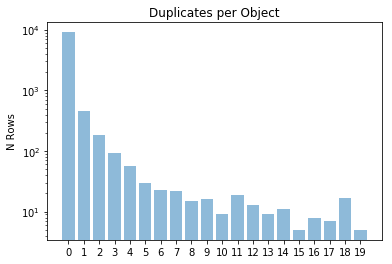

In [14]:
from collections import defaultdict 

import matplotlib.pyplot as plt;
import numpy as np
import matplotlib.pyplot as plt

buckets = defaultdict(int)
for n_dup in dups_distribution:
    buckets[n_dup - 1] += 1

x = np.arange(20)
y = [buckets[val] for val in x]
 
plt.bar(x, y, align='center', alpha=0.5, log=True)
plt.xticks(x, x)
plt.ylabel('N Rows')
plt.title('Duplicates per Object')
plt.show()

### Other Numbers

#### Flter by the `relation`, then the duplicate distribution is:
- Median number of duplicates: 1.0
- Mean number of duplicates: 54.792947297427496
- Stdev number of duplicates: 260.91925676565364
- `subject_name`s with 1 duplicate: 6155 ~ 56.7%
- `subject_name`s with 9+ duplicates: 1756

#### Filter by the `relation`, then the duplicate distribution is:
- Median number of duplicates: 1.0
- Mean number of duplicates: 13.306869640620484
- Stdev number of duplicates: 86.82547513692815
- `subject_name`s with 1 duplicate: 8613 ~ 79.4%
- `subject_name`s with 9+ duplicates: 622

### Discussion

Given a algorithm is able to determine the relation, the best it can do without resorting to guessing is 82.8% accuracy.

### Freebase Mid Sample Differences

Here we take a look at the sample. We print the features that change between different duplicates.

The below cell block can output millions of rows; therefore, we try to curb that with sampling. 

In [ ]:
import random
import pprint
import string

pp = pprint.PrettyPrinter(indent=2)

def remove_punctuation(s):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in s if ch not in exclude)

def is_subject_name_in_subject(subject_name, subject):
    subject = remove_punctuation(subject).lower().replace(' ', '')
    subject_name = remove_punctuation(subject_name).lower().replace(' ', '')
    return subject_name in subject

def weighted_gini_impurity(k):
    # Gini impurity is a measure of how often a randomly chosen element from the set would be
    # incorrectly labeled if it was randomly labeled according to the distribution of labels
    # in the subset. 
    total = sum(k[1].values())
    ret = 1
    for val in k[1].values():
        ret -= (val / total) ** 2
    return ret * total

for row in tqdm_notebook(dups_data):
    mids = list(row['Duplicate MIDs']) + [row['True MID']]
    mids = random.sample(['<http://rdf.freebase.com/ns/m.' + mid + '>' for mid in mids],
                         min(len(mids), 5))
    # TODO: add suject = ANY
    cursor.execute("""
        SELECT object, relation, subject
        FROM fb
        WHERE object = ANY(%s)
    """, (mids,))
    rows = cursor.fetchall()
    differences = defaultdict(set)
    for object_, relation, subject in rows:
        if ((is_subject_name_in_subject(row['Subject Name'], subject) and
            relation in ['<http://rdf.freebase.com/ns/common.topic.topic_equivalent_webpage>',
                        '<http://rdf.freebase.com/ns/type.object.name>',
                        '<http://www.w3.org/2000/01/rdf-schema#label>',
                        '<http://rdf.freebase.com/key/wikipedia.en>']) 
            or 'musicbrainz.org' in subject
            or ('<http://rdf.freebase.com/ns/type.object.type>' in relation and
                'common' not in subject)):
            mid = object_.replace('<http://rdf.freebase.com/ns/m.', '').rstrip('>')
            differences[relation].add(tuple([subject, mid]))
    print('\n\n--------------------------------------------\n\n')
    print('QUESTION:', row['Question'])
    print('SUBJECT NAME:', row['Subject Name'])
    print('MIDs:', mids)
    print('TOTAL MIDS:', len(row['Duplicate MIDs']) + 1)
    for relation, subjects in differences.items():
        print(relation + ' → ')
        pp.pprint(sorted(list(subjects), key=lambda k: k[1]))   
        print()

### Difference Bucket

Here we take a look at differences between the Freebase Samples. Do there exist features that can help you determine the correct MID?

[0] who was the artist on the album just you, just me
- **Subject Name:** just you , just me
- **Relation:** music/album/artist
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Artists
- **Duplicate Examples:**
  - By Lester Young: http://musicbrainz.org/release-group/eabdc911-a9bf-3340-9b43-c3dc9f3e26fa
  - By Alice Babs: http://musicbrainz.org/release-group/7a2f6f74-2583-35eb-90c6-532064abdae9

[1] what type of school is central high school
- **Subject Name:** central high school
- **Relation:** education/educational_institution/school_type
- **Number of Duplicate MIDs:** 31
- **Bucket:** Different States
- **Duplicate Examples:**
   - https://en.wikipedia.org/wiki/Central_High_School_(Cape_Girardeau,_Missouri)
   - http://en.wikipedia.org/wiki/Central_High_School_(Grand_Junction,_Colorado)
   - https://en.wikipedia.org/wiki/Central_High_School_(East_Chicago,_Indiana)
   - https://en.wikipedia.org/wiki/Central_High_School_(Carrollton,_Georgia)

[2] who designed the costume for the movie copenhagen
- **Subject Name:** copenhagen
- **Relation:** film/film/costume_design_by
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Years
- **Duplicate Examples:**
    - http://en.wikipedia.org/wiki/Copenhagen_(2002_film)
    - http://en.wikipedia.org/wiki/Copenhagen_(2014_film)

[3] What's a temple found in chiang mai
- **Subject Name:** chiang mai
- **Relation:** location/location/contains
- **Number of Duplicate MIDs:** 2
- **Bucket:** Province vs City
- **Duplicate Examples:**
    - https://en.wikipedia.org/wiki/Chiang_Mai_Province
    - https://en.wikipedia.org/wiki/Chiang_Mai

[4] what is canonical version of ethics?
- **Subject Name:** ethics
- **Relation:** music/recording/canonical_version
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Artists
- **Duplicate Examples:**
    - http://musicbrainz.org/recording/b3e3f2dd-20aa-4ed5-a343-369971552e6c
    - http://musicbrainz.org/recording/557d23bb-5e17-48c5-be2d-a72cb63eeae5

[5] what is the mpaa rating for the movie sahara
- **Subject Name:** sahara
- **Relation:** film/film/rating
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Year
- **Duplicate Examples:**
    - http://de.wikipedia.org/wiki/Sahara_(1983)
    - http://en.wikipedia.org/wiki/Sahara_(2005_film)

[6] what is the name of the title track for the recording  venus
- **Subject Name:** venus
- **Relation:** music/recording/tracks
- **Number of Duplicate MIDs:** 482
- **Bucket:** Different Artist
- **Duplicate Examples:**
    - http://musicbrainz.org/recording/35b01fa0-67cd-4671-841b-f71b9271540e
    - http://musicbrainz.org/recording/c2f033eb-9ac6-40d4-ad7c-bdef11c2c676
    - http://musicbrainz.org/recording/0fe7f127-27c1-4394-b324-e0990497d028
    - http://musicbrainz.org/recording/e1e97f4f-221c-4026-9177-d156c360c3a8

[7] The release track armageddon is from which recording 
- **Subject Name:** armageddon
- **Relation:** music/release_track/recording
- **Number of Duplicate MIDs:** 298
- **Bucket:** Different Recordings
- **Duplicate Examples:**
    - https://musicbrainz.org/recording/191790fc-927b-4d70-b34a-9f3fd9204eb2
    - http://musicbrainz.org/recording/2335b7d2-fe19-4139-a6fa-c8315c6d02ce

[8] The release track cardiac arrest is from what body of work
- **Subject Name:** cardiac arrest
- **Relation:** music/release_track/recording
- **Number of Duplicate MIDs:** 32
- **Bucket:** Different Recordings
- **Duplicate Examples:**
   - https://musicbrainz.org/release/5fef8b5d-40b7-47b2-ade6-f07d7b9de0e3
   - https://musicbrainz.org/recording/2774f6f1-7eff-4193-99f3-8318daea406e

[9] Name a musician.
- **Subject Name:** musician
- **Relation:** people/profession/people_with_this_profession
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Freebase types
- **Duplicate Examples:** 
    - "A musician is a person who plays a musical instrument or is musically talented, or one who composes, conducts, or performs music.\nMusicians can specialize in any musical style, and some musicians play in a variety of different styles. Examples of a musician's possible skills include performing, conducting, singing, composing, arranging, and the orchestration of music."@en
    - "A Musician is anyone who sings or plays a musical instrument, as a solo act, supporting artists, or as part of a musical group.  Musicians may also be typed as Musical Artist to capture additional data such as recordings made (either as a solo act or as a contributor to a track or album) and concert tours (for solo acts)."@en

[10] Name an actor
- **Subject Name:** actor
- **Relation:** people/profession/people_with_this_profession
- **Number of Duplicate MIDs:** 19
- **Bucket:** No Differences

[11] what is the release track on o holy night
- **Subject Name:** o holy night
- **Relation:** music/release_track/recording
- **Number of Duplicate MIDs:** 1249
- **Bucket:** Different Recordings
- **Duplicate Examples:**
   - https://musicbrainz.org/recording/4dd192bf-b0a1-4b2e-9a6a-c2c2ebd8ef2a
   - https://musicbrainz.org/recording/1f4d9785-e123-4ee2-9a10-b1205cd56269

[12] what format was set yourself on fire  released on
- **Subject Name:** set yourself on fire
- **Relation:** music/release/format
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Formats
- **Duplicate Examples:**
    - Vinyl: http://musicbrainz.org/release/02b4956c-2013-4ceb-af6d-a0edd87b94b9
    - CD: http://musicbrainz.org/release/6a99fd7b-c9e5-399c-b68e-9609c6cdd393

[13] what recording has the track the cleansing
- **Subject Name:** the cleansing
- **Relation:** music/release_track/recording
- **Number of Duplicate MIDs:** 29
- **Bucket:** Different Recordings
- **Duplicate Examples:**
    - http://musicbrainz.org/recording/1f9afd4b-8fa4-46a1-bb18-c0ea28c030f5
    - http://musicbrainz.org/recording/603dd142-f414-4cb9-bbbe-8734e16c8037

[14] What album was daybreak released from
- **Subject Name:** daybreak
- **Relation:** music/release_track/release
- **Number of Duplicate MIDs:** 376
- **Bucket:** Different Releases
- **Duplicate Examples:**
    - https://musicbrainz.org/recording/c2bc456c-f38c-4542-af95-dc3244b5ca70
    - https://musicbrainz.org/recording/09ca0e16-5e72-4167-a6ec-91cca0f44ab2
    
[15] what was the format of the release bionic
- **Subject Name:** bionic
- **Relation:** music/release/format
- **Number of Duplicate MIDs:** 6
- **Bucket:** Different Releases Internationally
- **Duplicate Examples:**
    - https://musicbrainz.org/release/48049b18-b950-4446-8fc8-76a8dba1a779
    - https://musicbrainz.org/release/88e54987-de4b-3101-943a-238016016134
    - https://musicbrainz.org/release/e17fe636-c5f1-4fd4-a6c2-b0f1855778d9

[16] What is a recording of the song pablo picasso?
- **Subject Name:** pablo picasso
- **Relation:** music/release_track/recording
- **Number of Duplicate MIDs:** 53
- **Bucket:** Different Recordings
- **Duplicate Examples:**
    - http://musicbrainz.org/release/89c14251-854b-4b04-9726-17936aaec96a
    - http://www.discogs.com/release/1067499

[17] congo was recorded as a part of what release?
- **Subject Name:** congo
- **Relation:** music/recording/releases
- **Number of Duplicate MIDs:** 38
- **Bucket:** Different Releases
- **Duplicate Examples:**
    - https://musicbrainz.org/recording/99b16048-6e66-4782-9163-937a5a24ff4a
    - https://musicbrainz.org/recording/7e77178f-38bb-449f-be98-8740fb88cf28
    - https://musicbrainz.org/recording/c44d1a12-bd14-4d9d-8e78-821fded2c4b9

[18] what was released by gold
- **Subject Name:** gold
- **Relation:** music/release_track/release
- **Number of Duplicate MIDs:** 655
- **Bucket:** Different Releases
- **Duplicate Examples:**
    - https://www.discogs.com/release/150463
    - https://musicbrainz.org/release/c7cb6b2f-b951-41b8-a3e6-e92282bf7c8d

[19] What is the subject of the book secrets?
- **Subject Name:** secrets
- **Relation:** book/written_work/subjects
- **Number of Duplicate MIDs:** 3
- **Bucket:** Different Books
- **Duplicate Examples:**
    - "Secrets is a book by Nuruddin Farah."
    - "Secrets is a children's book by Jacqueline Wilson, published in 2002 by Corgi. \"Secrets\" is told from the point of view of two pre-adolescent girls, Treasure and India, via their diary entries. Despite their very different backgrounds, the girls strike up a friendship and their stories begin to intertwine. The Diary of Anne Frank is frequently referred to in the novel and influences the girls' actions."@en

[20] What album features the song atlanta
- **Subject Name:** atlanta
- **Relation:** music/recording/releases
- **Number of Duplicate MIDs:** 38
- **Bucket:** Different Releases
- **Duplicate Examples:**
    - https://musicbrainz.org/recording/7324c45e-5d59-4b19-b03d-751c6bccfd2d
    - https://musicbrainz.org/recording/5def9c4c-386f-4807-941a-21c5eab6774b
    - https://musicbrainz.org/recording/617663a4-76d1-48f8-9df0-941b99fb102d

[21] Which female was born in paris?
- **Subject Name:** paris
- **Relation:** location/location/people_born_here
- **Number of Duplicate MIDs:** 12
- **Bucket:** Different Locations
- **Duplicate Examples:**
    - Paris, Tennessee
    - Paris, Illinois
    - Paris, Maine
    - Paris, New York

[22] where was the movie blood: the last vampire released
- **Subject Name:** blood : the last vampire
- **Relation:** film/film/country
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Films
- **Duplicate Examples:**
    - https://en.wikipedia.org/wiki/Blood:_The_Last_Vampire_(2009_film)
    - https://en.wikipedia.org/wiki/Blood:_The_Last_Vampire

[23] who is the producer of armageddon
- **Subject Name:** armageddon
- **Relation:** film/film/produced_by
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Films
- **Duplicate Examples
    - http://en.wikipedia.org/wiki/Armageddon_(1997_film)
    - http://en.wikipedia.org/wiki/Armageddon_(1998_film)

[24] what country released the movie under the skin
- **Subject Name:** under the skin
- **Relation:** film/film/country
- **Number of Duplicate MIDs:** 2
- **Bucket:** Different Movies
- **Duplicate Examples:**
    - http://en.wikipedia.org/wiki/Under_the_Skin_(2013_film)
    - http://en.wikipedia.org/wiki/Under_the_Skin_(1997_film)

[25] Which release is the track die in your arms from
- **Subject Name:** die in your arms
- **Relation:** music/release_track/release
- **Number of Duplicate MIDs:** 15
- **Bucket:** Same song name different artisits
- **Duplicate Examples:**
    - http://musicbrainz.org/release/c478f1e2-4296-4ba5-af7b-d7c983c36247
    - http://musicbrainz.org/release/4ffe38fb-772d-4d45-a3d9-8f929e03d695
    - http://musicbrainz.org/release/67a194fc-3cd2-4f66-96e5-aedeeb0eee01

### Discussion

Given the correct relation, the duplicate problem affects 20.6% of rows. The largest bottle neck in the end-to-end system. It is not clear that is bottleneck is possible to resolve. 

The assumpition that we can determine the top 1 relation is also not clear; it's purtent that we investigate different mappings of questions to relations. Does there exist features that can tell apart relations?

## Explore: Dev Relation not in Train

Hypothesis that there are unknown relations in the dev set. They are not seen during train time.

In [102]:
train_freq = defaultdict(int)
for index, row in tqdm_notebook(df_train.iterrows(), total=df_train.shape[0]):
    train_freq[row['relation']] += 1
print('%d unique relations in train' % (len(train_freq)))
print('Sample:', list(train_freq.items())[:5])

HBox(children=(IntProgress(value=0, max=75910), HTML(value='')))


1629 unique relations in train
Sample: [('music/artist/genre', 1553), ('book/written_work/subjects', 1092), ('music/release/track', 732), ('common/topic/notable_types', 1610), ('music/release/track_list', 679)]


In [106]:
unseen = 0
for index, row in tqdm_notebook(df_dev.iterrows(), total=df_dev.shape[0]):
    if row['relation'] not in train_freq:
        unseen += 1
print('%f%% rows with unseen relations in dev [%d of %d]' % (unseen / df_dev.shape[0] * 100, unseen, df_dev.shape[0]))

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


0.654680% rows with unseen relations in dev [71 of 10845]


In [108]:
infrequent = 0
for index, row in tqdm_notebook(df_dev.iterrows(), total=df_dev.shape[0]):
    if row['relation'] not in train_freq or train_freq[row['relation']] < 30:
        infrequent += 1
print('%f%% rows with infrequent relations in dev [%d of %d]' % (infrequent / df_dev.shape[0] * 100,
                                                       infrequent, df_dev.shape[0]))

HBox(children=(IntProgress(value=0, max=10845), HTML(value='')))


8.344859% rows with infrequent relations in train [905 of 10845]


### Discussion

91.6% of the time the relation in the development set has had over 30 examples; therefore, the bottleneck is not in unseen relationships. This does suggest that we need to consider data with a low number of examples.

## Experiment: Question Template to Relation Confusion 

Does the question contain enough information to differentiate between relations? Let's take a look at if multiple similar quetions map to different relations. It's important to look at the entity to differentiate between the relation.

In [ ]:
add_subject_name(df_train)

In [ ]:
from collections import defaultdict 
import pprint

template_to_relation = defaultdict(lambda: defaultdict(int))
df_train_subject_name_not_null = df_train[df_train.subject_name.notnull()]
for index, row in tqdm_notebook(df_train_subject_name_not_null.iterrows(),
                                total=df_train_subject_name_not_null.shape[0]):
    template = row['question'].replace(row['subject_name'], '<e>')
    template = template.strip().lower().strip('?.')
    template_to_relation[template][row['relation']] += 1
        
def weighted_gini_impurity(k):
    # Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled
    # if it was randomly labeled according to the distribution of labels in the subset. 
    total = sum(k[1].values())
    ret = 1
    for val in k[1].values():
        ret -= (val / total) ** 2
    return ret * total

pp = pprint.PrettyPrinter(indent=2)
print_dict = sorted(template_to_relation.items(), key=weighted_gini_impurity, reverse=True)[:20]
pp.pprint(print_dict)

In [28]:
expected_correct = 0
for index, row in tqdm_notebook(df_dev_subject_name_not_null.iterrows(), total=df_dev_subject_name_not_null.shape[0]):
    template = row['question'].replace(row['subject_name'], '<e>')
    template = template.strip().lower().strip('?.')
    if template in template_to_relation and row['relation'] in template_to_relation[template]:
        total = sum(template_to_relation[template].values())
        expected_correct += template_to_relation[template][row['relation']] / total
print('Template baseline accuracy:', expected_correct / df_dev_subject_name_not_null.shape[0])

HBox(children=(IntProgress(value=0, max=10379), HTML(value='')))


Template baseline: 0.4692397573345443
